<a href="https://colab.research.google.com/github/jobellet/detect_CS/blob/master/Tutorial_detect_cs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### First go to **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as Hardware accelerator


# **STEP 1: INSTALLING THE TOOLBOX**

In [0]:
import os
# Download U'n'Eye 
!git clone https://github.com/berenslab/uneye.git

# remove folders and files that are not needed
os.chdir('uneye')
import shutil
files = ['README.md','UnEye.ipynb','logo.jpeg','requirements_lin.txt','requirements_mac.txt','requirements_wind.txt','setup.py']
for i,f in enumerate(files):
    try:
        os.remove(f)
    except:
        print("File already deleted: ", f)
          
folders = ['.git','analysis scripts','data']
for i,f in enumerate(folders) :
    try:
        shutil.rmtree(f)
    except:
        print("Folder already deleted: ", f)
        
# add a patch to use U'n'Eye as a complex spike detector
!git clone https://github.com/jobellet/detect_CS.git

# to do math operations
import numpy as np
import scipy.io as io

# to read .mat files
!pip install mat4py
import mat4py
# to do read .pkl files
import pandas as pd

# to do clustering
!pip install hdbscan

import uneye
from detect_CS import *

#to download files from the internet
import urllib

Cloning into 'uneye'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 990 (delta 0), reused 1 (delta 0), pack-reused 987
Receiving objects: 100% (990/990), 169.39 MiB | 13.05 MiB/s, done.
Resolving deltas: 100% (209/209), done.
Checking out files: 100% (489/489), done.
Cloning into 'detect_CS'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 262 (delta 63), reused 36 (delta 16), pack-reused 157
Receiving objects: 100% (262/262), 670.68 KiB | 964.00 KiB/s, done.
Resolving deltas: 100% (148/148), done.
     |████████████████████████████████| 4.4MB 26kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.24-cp36-cp36m-linux_x86_64.whl size=2360711 sha256=dec124bc3e1

# Download an example file containing the extracellular recording of the potential near a cerebellar Purkinje cell and labels of some complex spikes (CSs)

In [0]:
file_link = 'https://ndownloader.figshare.com/files/21765003?private_link=a1f3eb9510b0a628ed28'

urllib.request.urlretrieve(file_link,'PC_EMI_S4_Right_10-08-2017.mat') # Download the file from Figshare server
example_file = mat4py.loadmat('PC_EMI_S4_Right_10-08-2017.mat') # Load the file in memory

## Let's display the 4 variables


In [0]:
print(example_file.keys())
sampling_rate = 25000; # Hz

RAW = np.array(example_file['RAW'])
HIGH = np.array(example_file['HIGH'])
Labels = np.array(example_file['Labels'])
Interval_inspected = np.array(example_file['Interval_inspected'])

dict_keys(['RAW', 'HIGH', 'Labels', 'Interval_inspected'])


## 1) The field 'RAW' is the broad-band electrophysiological signal

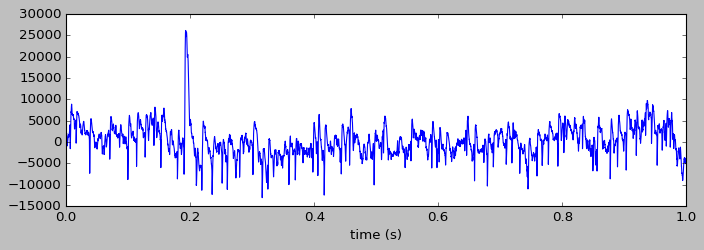

In [0]:
figure(figsize= (10,3))
plt.plot(np.arange(sampling_rate)/sampling_rate,RAW[0:sampling_rate])
plt.xlabel('time (s)')
plt.show()

## 2) The field 'HIGH' is the high-passed electrophysiological signal, revealing spikes

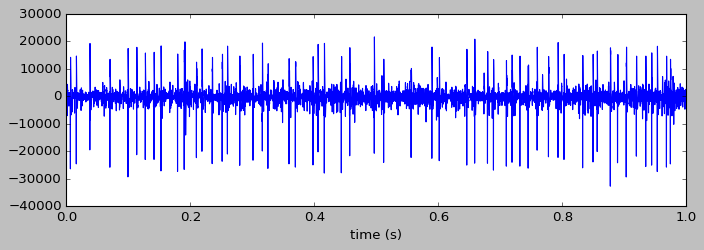

In [0]:
figure(figsize= (10,3))
plt.plot(np.arange(sampling_rate)/sampling_rate,HIGH[0:sampling_rate])
plt.xlabel('time (s)')
plt.show()

## 3) The field 'Labels' has the same dimension as the electrophysiological signals


### It is equal to 1 for time bins containing a complex spike and zero elsewhere.
#### Let's zoom arround the time of detected complex spike

<Figure size 800x240 with 0 Axes>

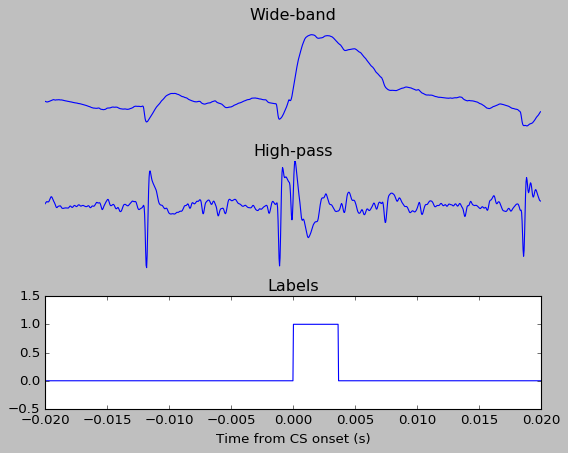

In [0]:
cs_onsets = np.where(np.diff(Labels)==1)[0].astype(int)
period_around_onset = np.arange(-sampling_rate/50,sampling_rate/50).astype(int);  # displaying 20 ms before and after the CS onset
figure(figsize= (10,3))
f, axarr = subplots(3,1)
axarr[0].plot(period_around_onset/sampling_rate,RAW[cs_onsets[0]+period_around_onset])

axarr[1].plot(period_around_onset/sampling_rate,HIGH[cs_onsets[0]+period_around_onset])
axarr[2].plot(period_around_onset/sampling_rate,Labels[cs_onsets[0]+period_around_onset])
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('on')
axarr[2].set_ylim(-.5,1.5)
axarr[0].set_title('Wide-band')
axarr[1].set_title('High-pass')
axarr[2].set_title('Labels')
axarr[2].set_xlabel('Time from CS onset (s)')
plt.show()

## 4) The field 'Interval_inspected' indicates the parts of the signal that the expert scrutinized to detect CSs

### It is equal to 1 for time bins observed and zero elsewhere.


<Figure size 1200x240 with 0 Axes>

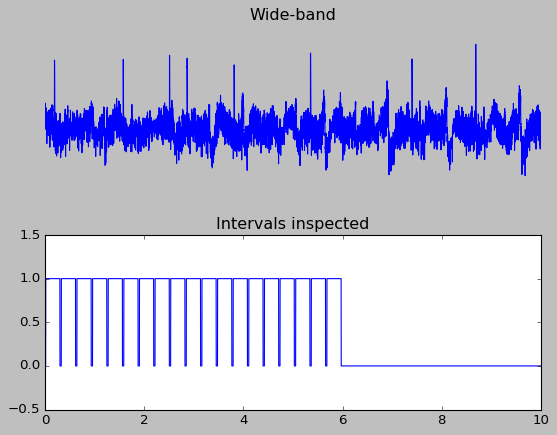

In [0]:
figure(figsize= (15,3))
f, axarr = subplots(2,1)
axarr[0].plot(np.arange(sampling_rate*10)/sampling_rate,RAW[0:sampling_rate*10])
axarr[1].plot(np.arange(sampling_rate*10)/sampling_rate,Interval_inspected[0:sampling_rate*10])
axarr[0].set_title('Wide-band')
axarr[1].set_title('Intervals inspected')
axarr[0].axis('off')
axarr[1].set_ylim(-.5,1.5)
plt.show()

# The first preprocessing function: 'load_data'
## 'load_data' opens a file and normalizes the signal so that it can be used to train a network or labeled by a trained network.

In [0]:
sampling_rate = 25000; # Hz
file_link = 'https://ndownloader.figshare.com/files/21765003?private_link=a1f3eb9510b0a628ed28'
urllib.request.urlretrieve(file_link,'PC_EMI_S4_Right_10-08-2017.mat') # Download a file and save it


LFP,High,Labels,Interval_inspected = load_data(filename = 'PC_EMI_S4_Right_10-08-2017.mat',# path of the file
                          # it can be a .mat file, a .pkl file or a .csv file
                          # set to [] if you use .csv files
                            field_LFP = ['RAW'],# in a .pkl file where the LFP data is in the key ['lfp'] then set: field_LFP = 'lfp'
                            # in a .mat file where the LFP data is in the variable lfp then set: field_LFP = 'lfp'
                            # in a .mat file where the LFP data is in the structure Data.lfp then set: field_LFP = ['Data','lfp']
                            # with .csv files this is the path to the file containing LFP
                            # load data will also automatically filter the wide-band signal if it is provided instead of the LFP hence we give the ['RAW'] field
                            field_high_pass = ['HIGH'], # same as above but the data has to be already high-passed
                            field_label = ['Labels'], # same as above
                            field_intervs = ['Interval_inspected'], # same as above
                            sampling_freq = sampling_rate # sampling frequency in Hz
                            )

# you can also load only one variable
# Like this:

#LFP,_,_,_= load_data(filename = 'PC_EMI_S4_Right_10-08-2017.mat',field_LFP = ['RAW'])

# Or like this:

#_,High,_,_= load_data(filename = 'PC_EMI_S4_Right_10-08-2017.mat',field_high_pass = ['HIGH'])

# etc.


# The second preprocessing function: 'concatenate_segments'
## 'concatenate_segments' concatenates the segments of signal that were inspected by the expert and that contain at least one CS. This results in signals with a reduced class imbalance (increased rate of CSs).

<Figure size 1200x240 with 0 Axes>

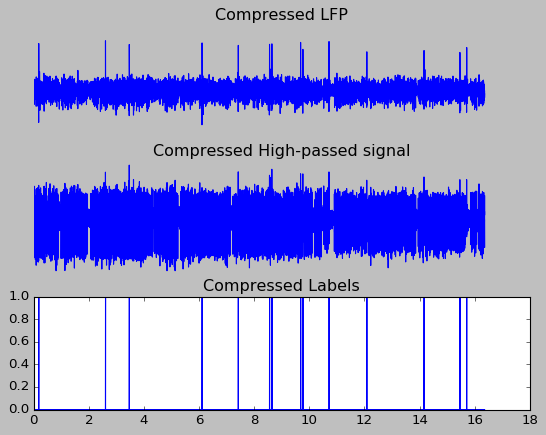

In [0]:
compLFP,compHIGH,compLabels = concatenate_segments(LFP,High,Interval_inspected,Labels)

figure(figsize= (15,3))
f, axarr = subplots(3,1)
axarr[0].plot(np.arange(len(compLFP))/sampling_rate,compLFP)
axarr[1].plot(np.arange(len(compLFP))/sampling_rate,compHIGH)
axarr[2].plot(np.arange(len(compLFP))/sampling_rate,compLabels)

axarr[0].set_title('Compressed LFP')
axarr[1].set_title('Compressed High-passed signal')
axarr[2].set_title('Compressed Labels')

axarr[0].axis('off')
axarr[1].axis('off')
plt.show()


# Training a network

### To train a network we will need a few example of complex spikes. 
### We will use the complex spikes obtained from different cells to obtain a network that can generalize to new cells

In [0]:
# Download the training set of our study
# It is already normalized and concatenated
file_link ='https://ndownloader.figshare.com/files/21809856?private_link=31e490395584c1eea69b'
urllib.request.urlretrieve(file_link,'training_set.mat') # The file training_set.mat contains all normalized and concatenated segments from our dataset

DATA = io.loadmat('training_set.mat')

ID = DATA['ID']
bigTraining_LFP = DATA['LFP'].squeeze()
bigTraining_HIGH = DATA['HIGH'].squeeze()
bigTraining_LABEL = DATA['LABEL'].squeeze()

def squizz(data):
    data = [x.squeeze() for x in data]
    return(data)
bigTraining_LFP = squizz(bigTraining_LFP)
bigTraining_HIGH = squizz(bigTraining_HIGH)
bigTraining_LABEL = squizz(bigTraining_LABEL)
DATA = None

### We will loop through our training set and merge segments from all Purkinje cells except the one we want to test our algorithm on  

In [0]:
length = int(sampling_rate*.5) # we will use only 500  millisecond of data from each cell
trainingLFP = []
trainingHIGH = []
trainingLabel = []
for ii,txt in enumerate(ID):
    if not(txt == 'PC_EMI_S4_Right_10-08-2017'):
            trainingLFP.append(bigTraining_LFP[ii][:length])
            trainingHIGH.append(bigTraining_HIGH[ii][:length])
            trainingLabel.append(bigTraining_LABEL[ii][:length])
    else:
        print('PC_EMI_S4_Right_10-08-2017 is skipped')
trainingLFP = np.concatenate(trainingLFP)  
trainingHIGH = np.concatenate(trainingHIGH)  
trainingLabel = np.concatenate(trainingLabel)  
print('the shape of the training set is: ' + str(trainingLFP.shape) +' for each input')

PC_EMI_S4_Right_10-08-2017 is skipped
the shape of the training set is: (1974138,) for each input


### Run the training

In [0]:
########################### Parameters that you should change for your own needs
# size of the convolutional and maxpooling operations
ks = 9 # convolution kernel size. NEED TO BE ODD.
mp = 7 # maxpooling size. NEED TO BE ODD.

# the number of bins (nb) taken into account by the network is given by
# nb = mp**2+mp**2*ks+(mp*ks)-mp+2*ks-2 

weights_name = 'Test' # the weights will be saved in the folder 'training'
sampfreq = 25000 # Sampling frequency of your signal in Hz
val_samples = 10 # If you have a small training set you should consider reducing this number.
                 # Otherwise the training will show an error
#########################
model = uneye.DNN(max_iter = 3000, ks=ks,mp=mp, weights_name=weights_name,
                  sampfreq = sampfreq,augmentation = False,val_samples = val_samples, doDiff = False)

model.train(trainingLFP,trainingHIGH,trainingLabel)

Number of classes: 2
Using GPU: True
Training. Please wait.
Early stopping at epoch 47 before overfitting occurred.
Model parameters saved to ./training/Test


#### Now use the trained model to predict complex spikes in the test file

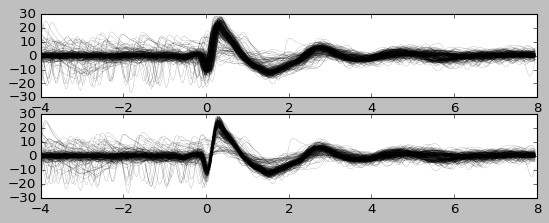

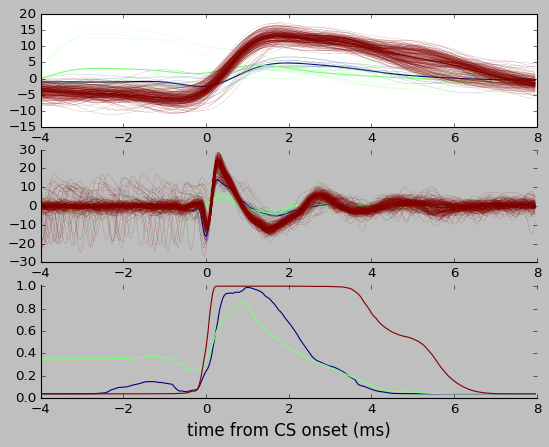

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


saving results.mat


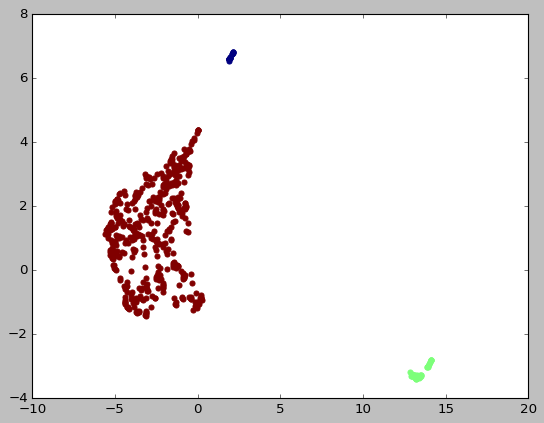

In [0]:
output = detect_CS(weights_name,
                   LFP,
                   High,
                   # The arguments above need to be given is this order
                
                   # The arguments bellow are optional

                   output_name = 'results.mat', # Here you write the path and name of the
                                       # file to save a .mat file of the results
                                       # default value: None , cluster_w = (0,2),plot = False, plot_w= (-4,8),plot_only_good = True
                   
                   sampling_frequency = sampfreq, # In Hz. Default value: 25000
                   ks=ks, # convolution kernel size. NEED TO BE ODD. Default value: 9
                   mp=mp, # maxpooling size. NEED TO BE ODD. Default value: 7
                   realign = True, # Realign waveforms in the range given by the variable 'alignment_w' before clustering
                                   # default value: True
                   alignment_w = (-.5,2), # Time (ms) before and after the putative CS onset used to realign onset
                                         # default value: (-.5,2)
                   cluster = True, # Perform dimensionality reduction and clustering in the window given by the parameter 'cluster_w'
                                  # default value: True
                   cluster_w = (0,2), # Time (ms) before and after the putative CS onset used to perform dimensionality reduction
                                      # default value: (0,2)
                   plot_w= (-4,8), # Time (ms) before and after the putative CS onset used to display waveforms
                                    # default value: (-4,8)
                   exlude_w = 3, # Minimum interval (in ms) of high predictive probability to consider a cluster of putative CSs as a real CSs
                                # default value: 3
                   plot = True, # Display waveforms (as in figure 2 of our paper)
                                # default value: False
                   plot_only_good = False, # If set to True, only the putative CSs kept by the algorithm are displayed
                                           # If set to False, the events that are too short are also displayed
                                           # default value: True
                   )


# **ALGORITHM OUTPUT:**
 
# The output of detect_CS is a dictionary containing 4 variables by default

In [0]:
print(output.keys())

dict_keys(['cs_onset', 'cs_offset', 'cluster_ID', 'embedding'])


- cs_onset is the time of CSs onsets. It is expressed in number of bins (not seconds or ms)

- cs_offset is the time of CSs offsets

- cluster_ID is a number assigned to each CS. It is the same for CSs with similar waveforms

- embedding is the projection of the waveform of each CS in 2 dimensions

### BONUS: Here we attempt to refine the predictions of the algorithm by using them as ground truth to train an other network. This allows to have multiple example of CSs from a same cell and potentially an expert algorithm (or overfitting). This procedure is repeated several times. This idea is not described in our paper because it as not been tested nor compared to other algorithm. You are welcome to try it and see if it gives satisfactory results.

In [0]:
for i in range(5):
    
    output = detect_CS(weights_name,
                   LFP,
                   High,sampling_frequency = 25000,
                   ks=ks,
                   mp=mp,
                   realign = True,
                   cluster = True,
                   cluster_w = (0,2),
                   exlude_w = 3)
    new_label = np.zeros_like(LFP).astype(bool);
    newIntervs = np.zeros_like(LFP).astype(bool);
    for o,e in zip(output['cs_onset'],output['cs_offset']):
        new_label[o:e] = True
        shifto=np.random.randint(sampling_rate/10)
        shifte=np.random.randint(sampling_rate/10)
        newIntervs[o-shifto:e+shifte] = True
    newcompLFP,newcompHIGH,newcompLabels = concatenate_segments(LFP,High,newIntervs,new_label)

    model = uneye.DNN(max_iter = 3000, ks=ks,mp=mp, weights_name=weights_name,
                  sampfreq = sampfreq,augmentation = False,val_samples = 10, doDiff = False)

    model.train(newcompLFP,newcompHIGH,newcompLabels)

Number of classes: 2
Using GPU: True
Training. Please wait.
Early stopping at epoch 90 before overfitting occurred.
Model parameters saved to ./training/Test
Number of classes: 2
Using GPU: True
Training. Please wait.
Early stopping at epoch 130 before overfitting occurred.
Model parameters saved to ./training/Test
Number of classes: 2
Using GPU: True
Training. Please wait.
Early stopping at epoch 93 before overfitting occurred.
Model parameters saved to ./training/Test
Number of classes: 2
Using GPU: True
Training. Please wait.
Early stopping at epoch 114 before overfitting occurred.
Model parameters saved to ./training/Test
Number of classes: 2
Using GPU: True
Training. Please wait.
Early stopping at epoch 97 before overfitting occurred.
Model parameters saved to ./training/Test


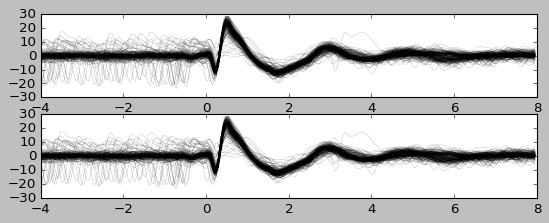

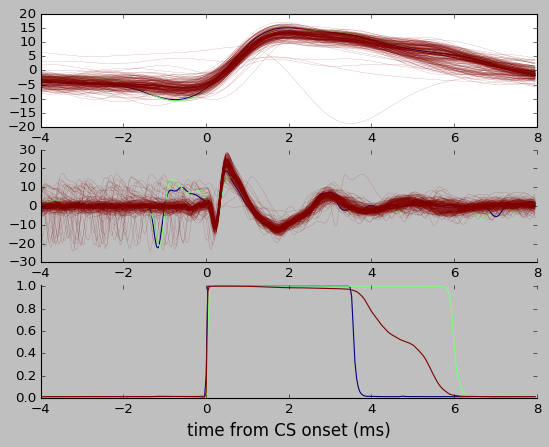

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


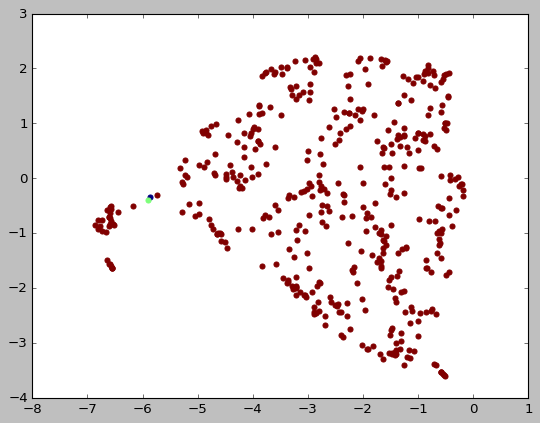

In [0]:
output = detect_CS(weights_name,
                   LFP,
                   High,
                   plot = True,
                   sampling_frequency = 25000,
                   ks=ks,
                   mp=mp,
                   realign = False,
                   cluster = True,
                   plot_only_good = False,
                   cluster_w = (0,2),
                   plot_w= (-4,8),
                   exlude_w = 3)